In [1]:
import torch
import gc
import torchvision.models as models
import torch.nn as nn

import finger_dataloader
import trainer
import visualizer

## Main Functions

Auto-reload files imported to the notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


For torch dataloader to use num_workers > 0, it relies on python multiprocessing, which in windows have deadlock issues, unless the instantiation is in a .py module and the code that invokes it is wrapped inside a \__main__ section.
https://github.com/pytorch/pytorch/issues/51344

torch.Size([3, 480, 640])


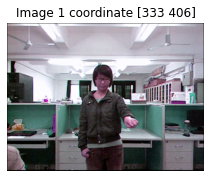

In [4]:
if __name__ == '__main__':
    loader_train, loader_val, loader_test = finger_dataloader.main(batch_size=10, num_workers=4)

In [10]:
# Free cuda memory
# Reference: https://discuss.pytorch.org/t/how-to-debug-causes-of-gpu-memory-leaks/6741/13
def freemem():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) and torch.is_tensor(obj.data):
            del obj
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

## Resnet18 Without tiles and utilizing the full dataset

Here we import the resnet18 model with pretrained weights. This gives us some good starting weights so that we don't have to train the model from scratch.

In [12]:
resnet18_notile_full = models.resnet18(pretrained=True)

From there, we replace the last layer to work with the tiles format rather than Resnet's standard classification. Lastly, we freeze all of the layers except for the newly added layer so that it can be trained individually

In [13]:
resnet18_notile_full.fc = nn.Linear(512, 480*640)
resnet18_notile_full.load_state_dict(torch.load('saved_models/resnet18_notile_full.model', map_location=torch.device(device)))
resnet18_notile_full = resnet18_notile_full.to(device)

Linear(in_features=512, out_features=307200, bias=True)


##### NOTE: remove the classification layer for the hand mask/ hand bounding box model, replace with linear layer with 2 output nodes for the regression task

In [14]:
resnet18_notile_full.fc = nn.Linear(512, 2)
for param in resnet18_notile_full.parameters():
    param.require_grad = False
resnet18_notile_full.fc.requires_grad_(True)

Linear(in_features=512, out_features=2, bias=True)

Now let's train the model!

##### NOTE: accuracy criteria for the fingertip coordinate regression task is the ratio of predictions that, when rounded to the closest integer, equal exactly to the label (pixel-level accuracy).

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
resnet18_notile_full = resnet18_notile_full.to(device)
trainer.train_fingertip(resnet18_notile_full, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

Device: cuda
Training epoch 1 batch 1250/2500, train loss = 8907.744248, train acc = 0.0081609
validation metrics at epoch 1 batch 1250: val loss = 2523.538171, val acc = 0.015333
Training epoch 1 batch 2500/2500, train loss = 5185.931780, train acc = 0.017680
validation metrics at epoch 1 batch 2500: val loss = 465.422207, val acc = 0.044000
Epoch 1/100 train loss = 5185.931780, train acc = 0.017680, val loss = 465.422207, val acc = 0.044000
Training epoch 2 batch 1250/2500, train loss = 469.411334, train acc = 0.051680
validation metrics at epoch 2 batch 1250: val loss = 162.311413, val acc = 0.026667
Training epoch 2 batch 2500/2500, train loss = 354.487623, train acc = 0.059120
validation metrics at epoch 2 batch 2500: val loss = 95.082804, val acc = 0.047333
Epoch 2/100 train loss = 354.487623, train acc = 0.059120, val loss = 95.082804, val acc = 0.047333
Training epoch 3 batch 1250/2500, train loss = 128.376106, train acc = 0.091200
validation metrics at epoch 3 batch 1250: val 

([2523.5381713867187,
  465.42220657348633,
  162.31141342163085,
  95.08280436197917,
  58.085415522257485,
  35.98906399408976,
  44.4219105275472,
  24.48762730916341,
  26.525959517161052,
  29.640992215474448,
  15.080779225031534,
  23.382018985748292,
  43.53421549479167,
  23.7954248491923,
  26.28595916112264,
  14.365604214668274,
  17.312378638585407,
  14.956928030649822,
  12.313137183189392,
  14.408742955525716,
  15.689447520573934,
  18.62500735282898,
  10.80161407470703,
  16.842625719706216,
  15.519256108601889,
  27.42252113342285,
  6.981652047634125,
  7.303517065048218,
  8.023972636858621,
  10.317307823499045,
  11.473906100591023,
  32.610028196970624,
  21.26453842798869,
  13.475213953653972,
  8.150291333198547,
  14.954267892837525,
  11.276109237670898],
 [0.015333333561817805,
  0.04400000070532163,
  0.026666667064030966,
  0.047333334038654966,
  0.1306666695078214,
  0.09800000165899594,
  0.10733333547910054,
  0.14000000298023224,
  0.095333335151

Unfreeze the layers and train with the fully unfrozen model

In [21]:
for param in resnet18_notile_full.parameters():
    param.require_grad = True
trainer.train_fingertip(resnet18_notile_full, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

torch.save(resnet18_notile_full.state_dict(), 'saved_models/resnet18_notile_full_fingertip.model')

Training epoch 1 batch 1250/2500, train loss = 7.516838, train acc = 0.333280
validation metrics at epoch 1 batch 1250: val loss = 10.286171, val acc = 0.216000
Training epoch 1 batch 2500/2500, train loss = 7.147893, train acc = 0.340520
validation metrics at epoch 1 batch 2500: val loss = 12.540260, val acc = 0.198667
current_patience = 9
Epoch 1/100 train loss = 7.147893, train acc = 0.340520, val loss = 12.540260, val acc = 0.198667
Training epoch 2 batch 1250/2500, train loss = 6.498808, train acc = 0.358960
validation metrics at epoch 2 batch 1250: val loss = 14.573902, val acc = 0.153333
current_patience = 8
Training epoch 2 batch 2500/2500, train loss = 6.918420, train acc = 0.351080
validation metrics at epoch 2 batch 2500: val loss = 24.870695, val acc = 0.108667
current_patience = 7
Epoch 2/100 train loss = 6.918420, train acc = 0.351080, val loss = 24.870695, val acc = 0.108667
Training epoch 3 batch 1250/2500, train loss = 6.359240, train acc = 0.359920
validation metrics 

## Model Visualizations

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


Load the model if you dont want to train it

In [ ]:
x, y = next(iter(loader_val))

resnet18_notile_full_2 = models.resnet18(pretrained=True)

resnet18_notile_full_2.fc = nn.Linear(512, x.shape[-2]*x.shape[-1])
print(resnet18_notile_full_2.fc)

for param in resnet18_notile_full_2.parameters():
    param.require_grad = False
resnet18_notile_full_2.fc.requires_grad_(True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
resnet18_notile_full_2 = resnet18_notile_full_2.to(device)
trainer.train(resnet18_notile_full_2, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

for param in resnet18_notile_full_2.parameters():
    param.require_grad = True
trainer.train(resnet18_notile_full_2, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

torch.save(resnet18_notile_full_2.state_dict(), 'saved_models/resnet18_notile_full_2.model')

Accuracy = 99.80127811431885%
Precision = 71.5584933757782%
Recall = 75.75492262840271%


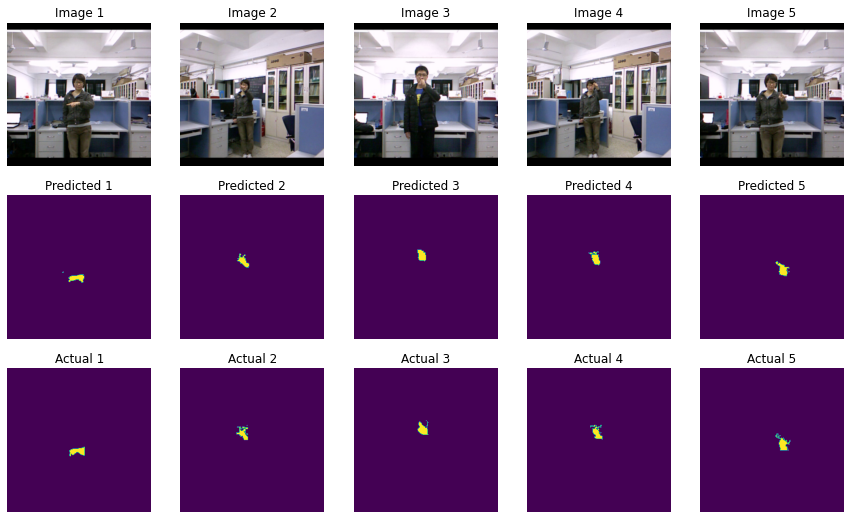

In [ ]:
visualizer.visualize_model_output(loader_test, resnet18_notile_full_2, device=device)